## Final Project
#### Summer 2021
**Authors:** GOAT Team (Estaban Aramayo, Ethan Haley, Claire Meyer, and Tyler Frankenburg)

##### Importing and exploring the Network Data

First, we'll import the Network data from Wikispeedia.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from urllib import parse
import nltk
from nltk.corpus import stopwords
import re
import os
from itertools import count

In [2]:
stop_words_lower = set(stopwords.words('english'))

In [3]:
doctexts = os.listdir('./plaintext_articles/')

In [4]:
len(doctexts) # So far so good--this is the right number of articles at least

4604

Check if the indexes align.  `articles` file has index 6 attached to "10th_century" article

In [5]:
doctexts[6]

'John_W._Campbell.txt'

OK well that's not good.  Next best hope is that "10th_century", exactly as in `articles`, at least has an exact name match in `doctexts`

In [6]:
"10th_century.txt" in doctexts

True

(breath of relief)

In [7]:
with open('plaintext_articles/10th_century.txt', 'r',  encoding='UTF-8') as txt:
    doc = txt.readlines()

In [8]:
doc[:5]

['   #copyright\n',
 '\n',
 '10th century\n',
 '\n',
 '2007 Schools Wikipedia Selection. Related subjects: General history\n']

In [9]:
doc = ' '.join([line.strip('\n') for line in doc])
doc_clean = " ".join(re.sub(r'[^a-zA-Z]', ' ' , w).lower() for w in doc.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_lower)
doc_clean = re.sub(r'\s+', ' ' , doc_clean)
doc_clean

' copyright th century schools wikipedia selection related subjects general history millennium st millennium bc st millennium nd millennium centuries th century th century th century decades s s s s s s s s s s means recording passage time th century century lasted overview tenth century usually regarded low point european history china also period political upheaval islamdom however cultural zenith especially spain medievalist historian technology lynn white said to modern eye nearly darkest dark ages concluded dark darkness womb similarly helen waddell wrote tenth century in textbooks disputes seventh bad eminence nadir human intellect even fifteenth century lorenzo valla described century lead iron events statue yogini goddess created kaveripakkam tamil nadu india th century enlarge statue yogini goddess created kaveripakkam tamil nadu india th century beginning medieval warm period viking groups settle northern france norse become normans foundation cluny first federated monastic o

**We've removed all numbers there.  Seems like 4 digit years would be meaningful, but then what about 3 digit years like in this tenth-century article?  And how much info is gained by having specific years in the article, semantically?  All those individual "s"es, by the way, are from decades.  Are those meaningful without just being a central node through which any unrelated topic can pass?  Very open for debate....**

To join each article with other data in other notebooks, we'll make a DataFrame with `article` column and cleaned text column.  The word "cleaned" seems a bit dirty at this point, but nevermind.

In [10]:
# collect all article names and cleaned texts in lists to make a DF
# (((((THIS IS A BIT SLOPPY, BOTH PROCESS AND CODE, SO TAKES ABOUT 30-60 SECS)))))
names = []
texts = []
for dt in doctexts:
    # read in single textfile, into a list of lines
    with open(f'plaintext_articles/{dt}', 'r',  encoding='UTF-8') as txt:
        doc = txt.readlines()
    # remove endlines
    doc = ' '.join([line.strip('\n') for line in doc])
    # eliminate stopwords and non-alpha characters
    doc_clean = " ".join(re.sub(r'[^a-zA-Z]', ' ' , w).lower() for w in doc.split() 
                         if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_lower)
    # reduce long whitespace to single spaces
    doc_clean = re.sub(r'\s+', ' ' , doc_clean)
    # append article name and "clean" text to lists
    names.append(dt.rstrip('.txt'))
    texts.append(doc_clean)

In [11]:
len(names) == len(texts) == 4604

True

In [12]:
docDF = pd.DataFrame({'article': names, 'texts': texts})

In [13]:
docDF.head(2)

,article,texts
0,Second_Crusade,copyright second crusade schools wikipedia se...
1,Navassa_Island,copyright navassa island schools wikipedia se...


In [14]:
# decode accents as for other files
docDF.article = docDF.article.apply(lambda x: parse.unquote(x))

In [15]:
docDF.texts[0][:100]

' copyright second crusade schools wikipedia selection related subjects military history war religiou'

That constant reflexivity of "copyright" and "wikipedia" is probably just the tip of the annoying iceberg, but let's erase it since we easily can.

In [16]:
docDF.texts = docDF.texts.apply(lambda txt: txt.replace('copyright', '').replace
                                ('schools wikipedia selection related subjects', ''))

In [17]:
docDF.head(2)

,article,texts
0,Second_Crusade,second crusade military history war religio...
1,Navassa_Island,navassa island north american geography nav...


In [18]:
# clean up memory
texts = ''
names = ''

#### Load and process other data files

In [19]:
# The list of all articles.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
articles = pd.read_csv("https://raw.githubusercontent.com/ebhtra/gory-graph/TF3/Wikispeedia/wikispeedia_paths-and-graph/articles.tsv", sep='\t', names = np.array(['article']), skiprows=12)

# decode UTF-8 special characters using urllib.parse.unquote()
articles['article'] = articles['article'].apply(lambda x: parse.unquote(x))

articles.head(10)

,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts
5,€2_commemorative_coins
6,10th_century
7,11th_century
8,12th_century
9,13th_century


In [20]:
# Hierarchical categories of all articles.
# Many articles have more than one category. Some articles have no category.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
categories = pd.read_csv("https://raw.githubusercontent.com/ebhtra/gory-graph/TF3/Wikispeedia/wikispeedia_paths-and-graph/categories.tsv", sep='\t', names = np.array(['article', 'category']), skiprows=13)

# decode UTF-8 special characters using urllib.parse.unquote()
categories['article'] = categories['article'].apply(lambda x: parse.unquote(x))
categories['category'] = categories['category'].apply(lambda x: re.sub(r'subject.', '' , x))
categories['category'] = categories['category'].apply(lambda x: re.split(r'\.', x))

categories.head()

,article,category
0,Áedán_mac_Gabráin,"[History, British_History, British_History_150..."
1,Áedán_mac_Gabráin,"[People, Historical_figures]"
2,Åland,[Countries]
3,Åland,"[Geography, European_Geography, European_Count..."
4,Édouard_Manet,"[People, Artists]"


We can see the category(ies) associated with all articles - many have more than one and some have none. We simplify by taking the first.

In [21]:
cats = categories['category'].apply(lambda x: pd.Series(list(x)))

In [22]:
col_names = {'article':'article', 0:'cat0', 1:'cat1', 2:'cat2'}

categories = pd.concat((categories['article'], cats), axis=1)
categories = categories.rename(columns=col_names, inplace=False)
categories

,article,cat0,cat1,cat2
0,Áedán_mac_Gabráin,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán_mac_Gabráin,People,Historical_figures,NaN
2,Åland,Countries,NaN,NaN
3,Åland,Geography,European_Geography,European_Countries
4,Édouard_Manet,People,Artists,NaN
...,...,...,...,...
5199,Zirconium,Science,Chemistry,Chemical_elements
5200,Zoroaster,People,Religious_figures_and_leaders,NaN
5201,Zuid-Gelders,Geography,European_Geography,NaN
5202,Zuid-Gelders,Language_and_literature,Languages,NaN


In [23]:
print(categories['cat0'].drop_duplicates())

0                      History
1                       People
2                    Countries
3                    Geography
9             Business_Studies
17                     Science
22               Everyday_life
32       Design_and_Technology
69                       Music
73                          IT
76     Language_and_literature
85                 Mathematics
91                    Religion
108                        Art
119                Citizenship
Name: cat0, dtype: object


In [24]:
categories1 = categories[['article', 'cat0']].drop_duplicates().reset_index()
#categories1['category'] = list(zip(categories1['cat0'], categories1['cat1']))
categories1 = categories1['cat0'].groupby(categories1['article']).apply(', '.join).reset_index()
categories1

,article,cat0
0,10th_century,History
1,11th_century,History
2,12th_century,History
3,13th_century,History
4,14th_century,History
...,...,...
4593,Åland,"Countries, Geography"
4594,Édouard_Manet,People
4595,Éire,"Countries, Geography"
4596,Óengus_I_of_the_Picts,"History, People"


In [25]:
print(categories1['cat0'].drop_duplicates())

0                                              History
7                                              Science
12                                       Everyday_life
14                                           Geography
22                               Design_and_Technology
                             ...                      
3877                                   Science, People
4092    Design_and_Technology, Language_and_literature
4390                             Everyday_life, People
4438                Geography, Language_and_literature
4586                                  People, Religion
Name: cat0, Length: 77, dtype: object


We also import a `links` file, which contains all links between articles. We decode similarly, and have a dataframe of pages and their linked articles.

In [26]:
# The list of all links between articles.
links = pd.read_csv("https://raw.githubusercontent.com/ebhtra/gory-graph/TF3/Wikispeedia/wikispeedia_paths-and-graph/links.tsv", sep='\t', names = np.array(['linkSource', 'linkTarget']), skiprows=12)

# decode UTF-8 special characters using urllib.parse.unquote()
links['linkSource'] = links['linkSource'].apply(lambda x: parse.unquote(x))
links['linkTarget'] = links['linkTarget'].apply(lambda x: parse.unquote(x))

links.head(10)

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
5,Áedán_mac_Gabráin,Isle_of_Man
6,Áedán_mac_Gabráin,Monarchy
7,Áedán_mac_Gabráin,Orkney
8,Áedán_mac_Gabráin,Picts
9,Áedán_mac_Gabráin,Scotland


The Wikispeedia dataset also includes finished (successfully played) paths, and unfinished (unsuccessful paths). We load those CSVs into dataframes as well, from which we can explore which connections game players were able to make. 

In [27]:
# Successful (i.e., finished) Wikispeedia paths.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
# Articles in a path are separated by ";".
# Back clicks are represented as "<".
# Ratings are optionally given by the user after finishing the game and range from 1 ("easy") to 5 ("brutal").
# Missing ratings are represented as "NULL".
paths_finished = pd.read_csv("https://raw.githubusercontent.com/ebhtra/gory-graph/TF3/Wikispeedia/wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', names = np.array(['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']), skiprows=16)

# decode UTF-8 special characters using urllib.parse.unquote()
paths_finished['path'] = paths_finished['path'].apply(lambda x: parse.unquote(x))

paths_finished.head(10)

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
5,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN
6,36dabfa133b20e3c,1249525912,112,14th_century;China;Gunpowder;Fire,2.0
7,20418ff4797f96be,1229188046,139,14th_century;Time;Isaac_Newton;Light;Color;Rai...,1.0
8,08888b1b428dd90e,1232241510,74,14th_century;Time;Light;Rainbow,3.0
9,08888b1b428dd90e,1232241601,167,14th_century;15th_century;Plato;Nature;Ultravi...,NaN


In [28]:
# Unsuccessful (i.e., unfinished) Wikispeedia paths.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
# Articles in a path are separated by ";".
# Back clicks are represented as "<".
# There are two types of quitting:
# (1) "timeout" means that no click was made for 30 minutes;
# (2) "restart" means that the user started a new game without finishing the current one.
paths_unfinished = pd.read_csv("https://raw.githubusercontent.com/ebhtra/gory-graph/TF3/Wikispeedia/wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', names = np.array(['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type']), skiprows=17)

# decode UTF-8 special characters using urllib.parse.unquote()
paths_unfinished['path'] = paths_unfinished['path'].apply(lambda x: parse.unquote(x))
paths_unfinished['target'] = paths_unfinished['target'].apply(lambda x: parse.unquote(x))

paths_unfinished.head(10)

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
5,131600803df4895e,1297100557,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout
6,486bb79910fe9dd2,1297101660,1932,Mind;Christianity;Europe;Renaissance;Ancient_G...,Scouting,timeout
7,6d136e371e42474f,1297102070,175,4-2-0;United_States;Agriculture;Sugar;Australia,Cane_Toad,restart
8,6d136e371e42474f,1297102100,19,Logic,Moon_landing,restart
9,6d136e371e42474f,1297104110,2006,Logic;Computer_science;Science;Physical_scienc...,Moon_landing,timeout


Finally, there is a CSV of the shortest-path distance between all article pairs, computed using the [Floyd-Warshall algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm).

In [29]:
# The shortest-path distances between all pairs of articles, computed using the Floyd-Warshall algorithm. (https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm)
# FORMAT:
# One row per article (the "source" of the shortest paths), in the same order as in articles.tsv.
# Each row contains the distances from the source to all articles (the "targets" of the shortest paths),
# again in the order of articles.tsv.
# The shortest-path distance is represented as a single digit, with no separators between values. This
# is possible because the longest shortest path happens to be of length 9.
# An underscore ("_") is used to indicate that the target cannot be reached from the source.
shortest_path = pd.read_csv("https://raw.githubusercontent.com/ebhtra/gory-graph/TF3/Wikispeedia/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt", sep='\t', names = np.array(['path']), skiprows=17)

shortest_path.head(10)

,path
0,0_____33333325634333435_2433544334_3_422343544...
1,_0____22222325623232424_2422544324_3_312242544...
2,__0___33222425623232324_2333444433_3_422343434...
3,___0__33333325634233334_2433434333_2_423343433...
4,____0_22323335633332435_2433545434_3_423343544...
5,_____032223324523222324_2332544333_3_422333544...
6,______01222324523232423_2222544334_3_422232544...
7,______10111414512131334_1311544323_2_311131544...
8,______11011414512131324_1311544323_2_311131544...
9,______22101325623232434_2422545434_3_422242544...


The format is challenging to glean value from, so we reformat into a matrix and clean up the data to allow more informative analysis. 

In [30]:
# Code source: https://stackoverflow.com/questions/43848680/pandas-split-dataframe-column-for-every-character
sp2 = shortest_path['path'].apply(lambda x: pd.Series(list(x)))

sp2

,0,1,2,3,4,5,6,7,8,9,...,4594,4595,4596,4597,4598,4599,4600,4601,4602,4603
0,0,_,_,_,_,_,3,3,3,3,...,4,3,3,4,4,3,4,4,4,2
1,_,0,_,_,_,_,2,2,2,2,...,4,2,3,4,4,3,4,3,3,3
2,_,_,0,_,_,_,3,3,2,2,...,4,3,2,3,4,3,4,3,3,3
3,_,_,_,0,_,_,3,3,3,3,...,4,2,2,3,4,3,4,4,3,3
4,_,_,_,_,0,_,2,2,3,2,...,4,2,3,4,4,3,4,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,_,_,_,_,_,_,2,2,2,2,...,3,2,2,3,3,0,3,3,3,2
4600,_,_,_,_,_,_,3,3,3,3,...,3,3,2,2,3,3,0,3,4,3
4601,_,_,_,_,_,_,2,2,2,2,...,3,2,2,3,4,3,3,0,3,3
4602,_,_,_,_,_,_,3,3,3,3,...,4,3,3,4,4,3,5,4,0,3


In [31]:
# Rename columns & provide a name for rows
sp_names = sp2.rename(columns=articles['article'], inplace=False)
sp_names = sp_names.rename(index=articles['article'], inplace=False)

sp_names

,Áedán_mac_Gabráin,Åland,Édouard_Manet,Éire,Óengus_I_of_the_Picts,€2_commemorative_coins,10th_century,11th_century,12th_century,13th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
Áedán_mac_Gabráin,0,_,_,_,_,_,3,3,3,3,...,4,3,3,4,4,3,4,4,4,2
Åland,_,0,_,_,_,_,2,2,2,2,...,4,2,3,4,4,3,4,3,3,3
Édouard_Manet,_,_,0,_,_,_,3,3,2,2,...,4,3,2,3,4,3,4,3,3,3
Éire,_,_,_,0,_,_,3,3,3,3,...,4,2,2,3,4,3,4,4,3,3
Óengus_I_of_the_Picts,_,_,_,_,0,_,2,2,3,2,...,4,2,3,4,4,3,4,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zionism,_,_,_,_,_,_,2,2,2,2,...,3,2,2,3,3,0,3,3,3,2
Zirconium,_,_,_,_,_,_,3,3,3,3,...,3,3,2,2,3,3,0,3,4,3
Zoroaster,_,_,_,_,_,_,2,2,2,2,...,3,2,2,3,4,3,3,0,3,3
Zuid-Gelders,_,_,_,_,_,_,3,3,3,3,...,4,3,3,4,4,3,5,4,0,3


In [32]:
# clean the data a bit, make the _ into NaN so we can make the remainder numeric
sp_names = sp_names.mask(sp_names == "_",np.nan)
# make numeric
sp_names = sp_names.apply(pd.to_numeric)

In [33]:
sp_names.head()

,Áedán_mac_Gabráin,Åland,Édouard_Manet,Éire,Óengus_I_of_the_Picts,€2_commemorative_coins,10th_century,11th_century,12th_century,13th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
Áedán_mac_Gabráin,0.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,2.0
Åland,NaN,0.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0
Édouard_Manet,NaN,NaN,0.0,NaN,NaN,NaN,3.0,3.0,2.0,2.0,...,4.0,3.0,2.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0
Éire,NaN,NaN,NaN,0.0,NaN,NaN,3.0,3.0,3.0,3.0,...,4.0,2.0,2.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
Óengus_I_of_the_Picts,NaN,NaN,NaN,NaN,0.0,NaN,2.0,2.0,3.0,2.0,...,4.0,2.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0


We find that the average distance across this matrix is 3.202.

In [36]:
# Average distance 
#https://stackoverflow.com/questions/25140998/pandas-compute-mean-or-std-standard-deviation-over-entire-dataframe
avg = sp_names.stack().mean()
print(avg)

3.201729547596255


In [37]:
np.nanmean(sp_names)

3.201729547596255

Some of the Link endpoint names don't exactly match the docDF.article names, and we need them to match exactly, so we can dig into and resolve errors.

In [40]:
linknames = set(links.linkSource.values).union(set(links.linkTarget.values))

In [41]:
len(linknames)

4592

In [42]:
errornames = [n for n in docDF.article if n not in linknames]
len(errornames)

306

In [43]:
errornames[:11]

['Andriyivskyy_Descen',
 'Fine_ar',
 'Giza_pyramid_comple',
 'Coconu',
 'Great_Ti',
 'Bernard_Hinaul',
 'Martin_Luther_King,_Jr',
 'Coo',
 'Eifel_Aqueduc',
 'Carro',
 'Diamond_cu']

For some reason, a lot of final 't' letters seem to be missing from the docDF article names. Let's see how many, and add a t.

In [44]:
docnames = set(docDF.article.values)
# make sure not to correct to a name that already exists
add_t = [n for n in errornames if (n + 't' in linknames) and (n + 't' not in docnames)]
len(add_t)

253

In [45]:
add_t = set(add_t)
copynames = docDF.article.values[:]
copynames = [cn + 't' if cn in add_t else cn for cn in copynames]

We can move on to remaining errors, using the copied array.

In [46]:
errornames = [n for n in copynames if n not in linknames]
len(errornames)

53

In [47]:
errornames

['Giza_pyramid_comple',
 'Martin_Luther_King,_Jr',
 'Archaeoptery',
 'Fermi_parado',
 'FairTa',
 'Manchester_United_F.C',
 'Sandy_Koufa',
 'Badugi',
 'Island_Fo',
 'H.D',
 'Earwa',
 'Wowpurchase',
 'Linu',
 'Nouakcho',
 'Monaco_Grand_Pri',
 'Floyd_Mayweather_Jr',
 'Private_Peaceful',
 'Body_mass_inde',
 'Walter_Sco',
 'The_Lora',
 'Thora',
 'Lone_Wolf_(gamebooks)',
 'Super_Mario_Bros',
 'Physical_parado',
 'Suikinkutsu',
 'Vacutainer',
 'Arp2_3_comple',
 'James_T._Aubrey,_Jr',
 'Wikipedia_Text_of_the_GNU_Free_Documentation_License',
 'Fo',
 'Underground_(stories)',
 'Schatzki_ring',
 'Wesse',
 'Douglas_DC-4',
 'Donation',
 'Tottenham_Hotspur_F.C',
 'Smallpo',
 'Bat-eared_Fo',
 'Karl_Mar',
 'Arsenal_F.C',
 'Dundee_United_F.C',
 'Chelsea_F.C',
 'Mozilla_Firefo',
 'Uni',
 'Liverpool_F.C',
 'John_Seigenthaler,_Sr',
 'Celtic_F.C',
 'Color_Graphics_Adapter',
 'Eso',
 'Washington,_D.C',
 'George_Fo',
 'Samuel_Becke',
 'James_Wa']

Looks like 'tt', 'x', and '.' at the end of names will take care of the bulk of the rest.

In [48]:
add_tt = set([n for n in errornames if (n + 'tt' in linknames) and (n + 'tt' not in docnames)])
len(add_tt)

4

In [49]:
add_x = set([n for n in errornames if (n + 'x' in linknames) and (n + 'x' not in docnames)])
len(add_x)

23

In [50]:
add_dot = set([n for n in errornames if (n + '.' in linknames) and (n + '.' not in docnames)])
len(add_dot)

14

In [51]:
copynames = [cn + 'tt' if cn in add_tt else cn for cn in copynames]
copynames = [cn + 'x' if cn in add_x else cn for cn in copynames]
copynames = [cn + '.' if cn in add_dot else cn for cn in copynames]

In [52]:
errornames = [n for n in copynames if n not in linknames]
errornames

['Badugi',
 'Wowpurchase',
 'Private_Peaceful',
 'Lone_Wolf_(gamebooks)',
 'Suikinkutsu',
 'Vacutainer',
 'Wikipedia_Text_of_the_GNU_Free_Documentation_License',
 'Underground_(stories)',
 'Schatzki_ring',
 'Douglas_DC-4',
 'Donation',
 'Color_Graphics_Adapter']

It's not clear what's happening with these final 12.  Perhaps reversing the order of checking for inclusion will help.

In [53]:
cnames = set(copynames)

In [54]:
missing = [n for n in linknames if n not in cnames]
len(missing)

2

In [55]:
missing

['Beet', 'Boat']

For our purposes, we can safely remove the 12 articles in docDF that have no link edges in the other file.   But "Beet" and "Boat" are presumably on many solution paths, so we may need to scrape those and add them to the docDF frame.

In [56]:
beet = "The beetroot is the taproot portion of a beet plant usually known in Canada and the USA as beets while the vegetable is referred to as beetroot in British English, and also known as the table beet, garden beet, red beet, dinner beet or golden beet. It is one of several cultivated varieties of Beta vulgaris grown for their edible taproots and leaves (called beet greens); they have been classified as B. vulgaris subsp. vulgaris Conditiva Group. Other cultivars of the same species include the sugar beet, the leaf vegetable known as chard or spinach beet, and mangelwurzel, which is a fodder crop. Three subspecies are typically recognized. Beets were domesticated in the ancient Middle East, primarily for their greens, and were grown by the Ancient Egyptians, Greeks and Romans. By the Roman era, it is thought that they were cultivated for their roots as well. From the Middle Ages, beetroot was used as a treatment for a variety of conditions, especially illnesses relating to digestion and the blood. Bartolomeo Platina recommended taking beetroot with garlic to nullify the effects of garlic-breath During the middle of the 19th century, wine often was coloured with beetroot juice."
boat = "A boat is a watercraft of a large range of types and sizes, but generally smaller than a ship, which is distinguished by its larger size, shape, cargo or passenger capacity, or its ability to carry boats. Small boats are typically found on inland waterways such as rivers and lakes, or in protected coastal areas. However, some boats, such as the whaleboat, were intended for use in an offshore environment. In modern naval terms, a boat is a vessel small enough to be carried aboard a ship. Anomalous definitions exist, as lake freighters 1,000 feet (300 m) long on the Great Lakes are called boats.Boats vary in proportion and construction methods with their intended purpose, available materials, or local traditions. Canoes have been used since prehistoric times and remain in use throughout the world for transportation, fishing, and sport. Fishing boats vary widely in style partly to match local conditions. Pleasure craft used in recreational boating include ski boats, pontoon boats, and sailboats. House boats may be used for vacationing or long-term residence. Lighters are used to convey cargo to and from large ships unable to get close to shore. Lifeboats have rescue and safety functions. Boats can be propelled by manpower (e.g. rowboats and paddle boats), wind (e.g. sailboats), and motor (including gasoline, diesel, and electric). Boats have served as transportation since the earliest times.[1] Circumstantial evidence, such as the early settlement of Australia over 40,000 years ago, findings in Crete dated 130,000 years ago,[2] and in Flores dated to 900,000 years ago,[3] suggest that boats have been used since prehistoric times. The earliest boats are thought to have been dugouts,[4] and the oldest boats found by archaeological excavation date from around 7,000–10,000 years ago. The oldest recovered boat in the world, the Pesse canoe, found in the Netherlands, is a dugout made from the hollowed tree trunk of a Pinus sylvestris that was constructed somewhere between 8200 and 7600 BC. This canoe is exhibited in the Drents Museum in Assen, Netherlands. Other very old dugout boats have also been recovered. Rafts have operated for at least 8,000 years. A 7,000-year-old seagoing reed boat has been found in Kuwait. Boats were used between 4000 and 3000 BC in Sumer, ancient Egypt and in the Indian Ocean.Boats played an important role in the commerce between the Indus Valley Civilization and Mesopotamia. Evidence of varying models of boats has also been discovered at various Indus Valley archaeological sites. Uru craft originate in Beypore, a village in south Calicut, Kerala, in southwestern India. This type of mammoth wooden ship was constructed solely of teak, with a transport capacity of 400 tonnes. The ancient Arabs and Greeks used such boats as trading vessels. The historians Herodotus, Pliny the Elder and Strabo record the use of boats for commerce, travel, and military purposes."

In [57]:
beet_clean = " ".join(re.sub(r'[^a-zA-Z]', ' ' , w).lower() for w in beet.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_lower)
beet_clean = re.sub(r'\s+', ' ' , beet_clean)
beet_clean

'beetroot taproot portion beet plant usually known canada usa beets vegetable referred beetroot british english also known table beet garden beet red beet dinner beet golden beet one several cultivated varieties beta vulgaris grown edible taproots leaves called beet greens classified b vulgaris subsp vulgaris conditiva group cultivars species include sugar beet leaf vegetable known chard spinach beet mangelwurzel fodder crop three subspecies typically recognized beets domesticated ancient middle east primarily greens grown ancient egyptians greeks romans roman era thought cultivated roots well middle ages beetroot used treatment variety conditions especially illnesses relating digestion blood bartolomeo platina recommended taking beetroot garlic nullify effects garlic breath middle th century wine often coloured beetroot juice '

In [58]:
boat_clean = " ".join(re.sub(r'[^a-zA-Z]', ' ' , w).lower() for w in boat.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_lower)
boat_clean = re.sub(r'\s+', ' ' , boat_clean)
boat_clean

'boat watercraft large range types sizes generally smaller ship distinguished larger size shape cargo passenger capacity ability carry boats small boats typically found inland waterways rivers lakes protected coastal areas however boats whaleboat intended use offshore environment modern naval terms boat vessel small enough carried aboard ship anomalous definitions exist lake freighters feet m long great lakes called boats boats vary proportion construction methods intended purpose available materials local traditions canoes used since prehistoric times remain use throughout world transportation fishing sport fishing boats vary widely style partly match local conditions pleasure craft used recreational boating include ski boats pontoon boats sailboats house boats may used vacationing long term residence lighters used convey cargo large ships unable get close shore lifeboats rescue safety functions boats propelled manpower e g rowboats paddle boats wind e g sailboats motor including gaso

In [59]:
docDF.article = copynames
keepers = [art not in errornames for art in copynames]
namekeep = docDF.article.values[keepers]
textkeep = docDF.texts.values[keepers]

In [60]:
namekeep = list(namekeep) + ['Beet', 'Boat']
textkeep = list(textkeep) + [beet_clean, boat_clean]
print(len(namekeep), len(textkeep))

4594 4594


In [61]:
docDF = pd.DataFrame({'article': namekeep, 'texts': textkeep})

In [62]:
docDF.tail()

,article,texts
4589,Banknote,banknote currency numismatics numismatic te...
4590,Weyto_language,weyto language languages weyto language bel...
4591,Marseille,marseille european geography ville de marse...
4592,Beet,beetroot taproot portion beet plant usually kn...
4593,Boat,boat watercraft large range types sizes genera...


In [63]:
# clean up memory
namekeep = ''
textkeep = ''

In [64]:
# save that DF so that we don't have to include this code in the submission notebook
docDF.to_csv('doctextDF.csv')

Then we can make a matrix of article pair semantic distances based on tfidf cosine differences.

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

In [66]:
t_vec=TfidfVectorizer()
t_vec.fit(docDF.texts)
tfidf_vectors=t_vec.transform(docDF.texts)
# outer product to get all similarities into a matrix
pairwise_similarities=np.dot(tfidf_vectors, tfidf_vectors.T).toarray()
# somehow the euc.dists build in the outer product step
pairwise_differences=euclidean_distances(tfidf_vectors)

In [67]:
# adapted/stolen from https://towardsdatascience.com/calculating-document-similarities-using-bert-and-other-models-b2c1a29c9630
def most_similar_N(doc_id, similarity_matrix, matrix, N):
    print(f'Document: {docDF.iloc[doc_id]["article"]}\n')
    print('Similar Documents:')
    if matrix == 'Cosine Similarity':
        similar_ix = np.argsort(similarity_matrix[doc_id])[::-1][:N+1]
    elif matrix == 'Euclidean Distance':
        similar_ix = np.argsort(similarity_matrix[doc_id])[:N+1] # same as previous line, essentially
    for ix in similar_ix:
        if ix == doc_id:  # don't measure self vs self
            continue
        print('\n')
        print(f'Document: {docDF.iloc[ix]["article"]}')
        print(f'{matrix} : {similarity_matrix[doc_id][ix]}')

# Second Crusade article, for example
most_similar_N(0, pairwise_similarities, 'Cosine Similarity', 20)
print("===========")
print("=========== Check Euclidean distances, in reverse, i.e. same order as above")
print("===========")
most_similar_N(0, pairwise_differences, 'Euclidean Distance', 20) 

Document: Second_Crusade

Similar Documents:


Document: First_Crusade
Cosine Similarity : 0.5636938399958338


Document: Crusades
Cosine Similarity : 0.5085333802507119


Document: Manuel_I_Komnenos
Cosine Similarity : 0.38542279865753126


Document: Children's_Crusade
Cosine Similarity : 0.37267426912228174


Document: German_Crusade,_1096
Cosine Similarity : 0.3373211731790233


Document: Byzantine_Empire
Cosine Similarity : 0.29820088845943765


Document: Siege_of_Antioch
Cosine Similarity : 0.2837476377305084


Document: Frederick_II,_Holy_Roman_Emperor
Cosine Similarity : 0.2537415253376982


Document: Albigensian_Crusade
Cosine Similarity : 0.23344682857791788


Document: Louis_XIV_of_France
Cosine Similarity : 0.21353974301740766


Document: Richard_I_of_England
Cosine Similarity : 0.19848800217703055


Document: Jerusalem
Cosine Similarity : 0.19029920240813405


Document: List_of_French_monarchs
Cosine Similarity : 0.19019358852149285


Document: Damascus
Cosine Similarity : 

This prints out the most similar documents, without assigning them to any variable.  The Euclidean Distance is just ordered opposite from the Cosine Similarity, so they measure the same thing, in reverse, but the scale is different.

We could use article similarity as a weighting on graph edges, in order to find shortest paths using something other than just number of links.  To do so, we need to subtract cosine similarity from 1 so that the shortest path algorithm can search for the lowest numbers.

In [68]:
pairwise_similarities[:2,:2]

array([[1.        , 0.01588951],
       [0.01588951, 1.        ]])

In [69]:
cosine_diffs = 1 - pairwise_similarities
cosine_diffs[:2,:2]

array([[-2.22044605e-15,  9.84110486e-01],
       [ 9.84110486e-01, -1.33226763e-15]])

Those rounding errors for self-similarities have drifted negative, which will break shortest path algorithms, so we'll eliminate them by making them be 1 instead of 0.  

In [70]:
cosine_diffs = np.where(cosine_diffs <= 0, 1, cosine_diffs)
cosine_diffs[:2,:2]

array([[1.        , 0.98411049],
       [0.98411049, 1.        ]])

In [71]:
cosine_diffs.shape

(4594, 4594)

##### Network Analysis and Graphing

Then we can build a directed graph representing how you could navigate around these articles by clicking their hyperlinks.  Use cosine distance between tfidf vectors for each node as connecting edge weight attribute.

In [72]:
DG = nx.DiGraph()
# create map from article names to tfidf distance matrix indexes
doc_ids = {article:idx for idx, article in enumerate(docDF.article)}

for source, target in zip(links.linkSource.values, links.linkTarget.values):
    cos_distance = cosine_diffs[doc_ids[source], doc_ids[target]]
    DG.add_edge(source, target, cos_dist=float(cos_distance), weight=1000*float(cos_distance)) # can't use numpy floats with graphml

In [73]:
DG_node_attr = categories1.set_index('article').to_dict('index')

for n in DG.nodes_iter(): DG.node[n]['category'] = 'None'
for key, value in DG_node_attr.items():
    if key in DG.nodes_iter():
        DG.node[key]['category'] = value['cat0']
    else:
        continue

In [74]:
DG.node['Orkney']

{'category': 'Geography'}

In [75]:
len(DG.edges())

119882

Text(0,0.5,'Number of Edges')

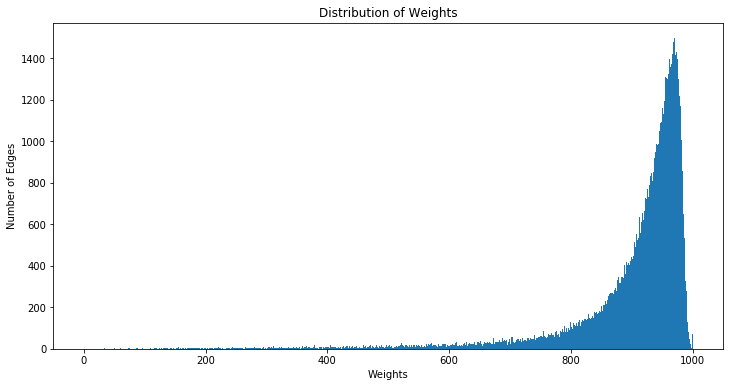

In [76]:
#nx.get_edge_attributes(DG, 'weight')
plt.figure(figsize=(12,6))


plt.hist(nx.get_edge_attributes(DG,'weight').values(), bins=1000)
plt.title('Distribution of Weights')
plt.xlabel('Weights')
plt.ylabel('Number of Edges')


Since the graph of links is directed, paths from A to B won't always have the same length as paths from B to A:

In [77]:
print(sp_names.loc['Fruit', 'Walt_Disney'], sp_names.loc['Walt_Disney', 'Fruit'])

3.0 2.0


In [78]:
nx.shortest_path(DG, 'Fruit', 'Walt_Disney')

['Fruit', 'Apple', 'Johnny_Appleseed', 'Walt_Disney']

In [79]:
nx.shortest_path(DG, 'Walt_Disney', 'Fruit')

['Walt_Disney', 'California', 'Fruit']

The path from general to specific took longer than the other way, in this case.  Let's test that notion on another pair.

In [80]:
nx.shortest_path(DG, 'Weather', 'David_Beckham')

['Weather',
 'Acid_rain',
 'Manchester',
 'Manchester_United_F.C.',
 'David_Beckham']

In [81]:
nx.shortest_path(DG, 'David_Beckham', 'Weather')

['David_Beckham', 'England', 'Birmingham', 'Weather']

In [82]:
nx.shortest_path(DG, 'Natalie_Portman', 'Romania')

['Natalie_Portman', 'Romania']

In [83]:
nx.shortest_path(DG, 'Romania', 'Natalie_Portman')

['Romania', 'Crimean_War', 'Jerusalem', 'Natalie_Portman']

That asymmetry highlights a problem with using path distance as a proxy for semantic relatedness.

#### With cosine distances as edge weights now, we can also measure a shortest path in terms of how low the total edge distance is between source and target.

In [84]:
nx.shortest_path(DG, 'Natalie_Portman', 'Romania', weight='cos_dist')

['Natalie_Portman', 'Romania']

In [85]:
nx.shortest_path_length(DG, 'Natalie_Portman', 'Romania', weight='cos_dist')

0.9742942193969387

In [86]:
print(nx.shortest_path(DG, 'Weather', 'David_Beckham', weight='cos_dist'))
nx.shortest_path_length(DG, 'Weather', 'David_Beckham', weight='cos_dist')

['Weather', 'Acid_rain', 'Manchester', 'Manchester_United_F.C.', 'David_Beckham']


3.214608012197848

In [87]:
# Ran this once, so commenting it out
#nx.write_graphml(DG, 'weighted_link_dg.graphml')

In [88]:
print(nx.info(DG))

Name: 
Type: DiGraph
Number of nodes: 4592
Number of edges: 119882
Average in degree:  26.1067
Average out degree:  26.1067


In [89]:
#Look at weakly connected subgraphs of the DiGraph
sg = list(nx.weakly_connected_component_subgraphs(DG))

for i in range(len(sg)):
    print(nx.info(sg[i]))


Name: 
Type: DiGraph
Number of nodes: 4589
Number of edges: 119879
Average in degree:  26.1231
Average out degree:  26.1231
Name: 
Type: DiGraph
Number of nodes: 3
Number of edges: 3
Average in degree:   1.0000
Average out degree:   1.0000


In [90]:
DG0 = sg[0]

/Users/clairemeyer/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/clairemeyer/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/clairemeyer/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


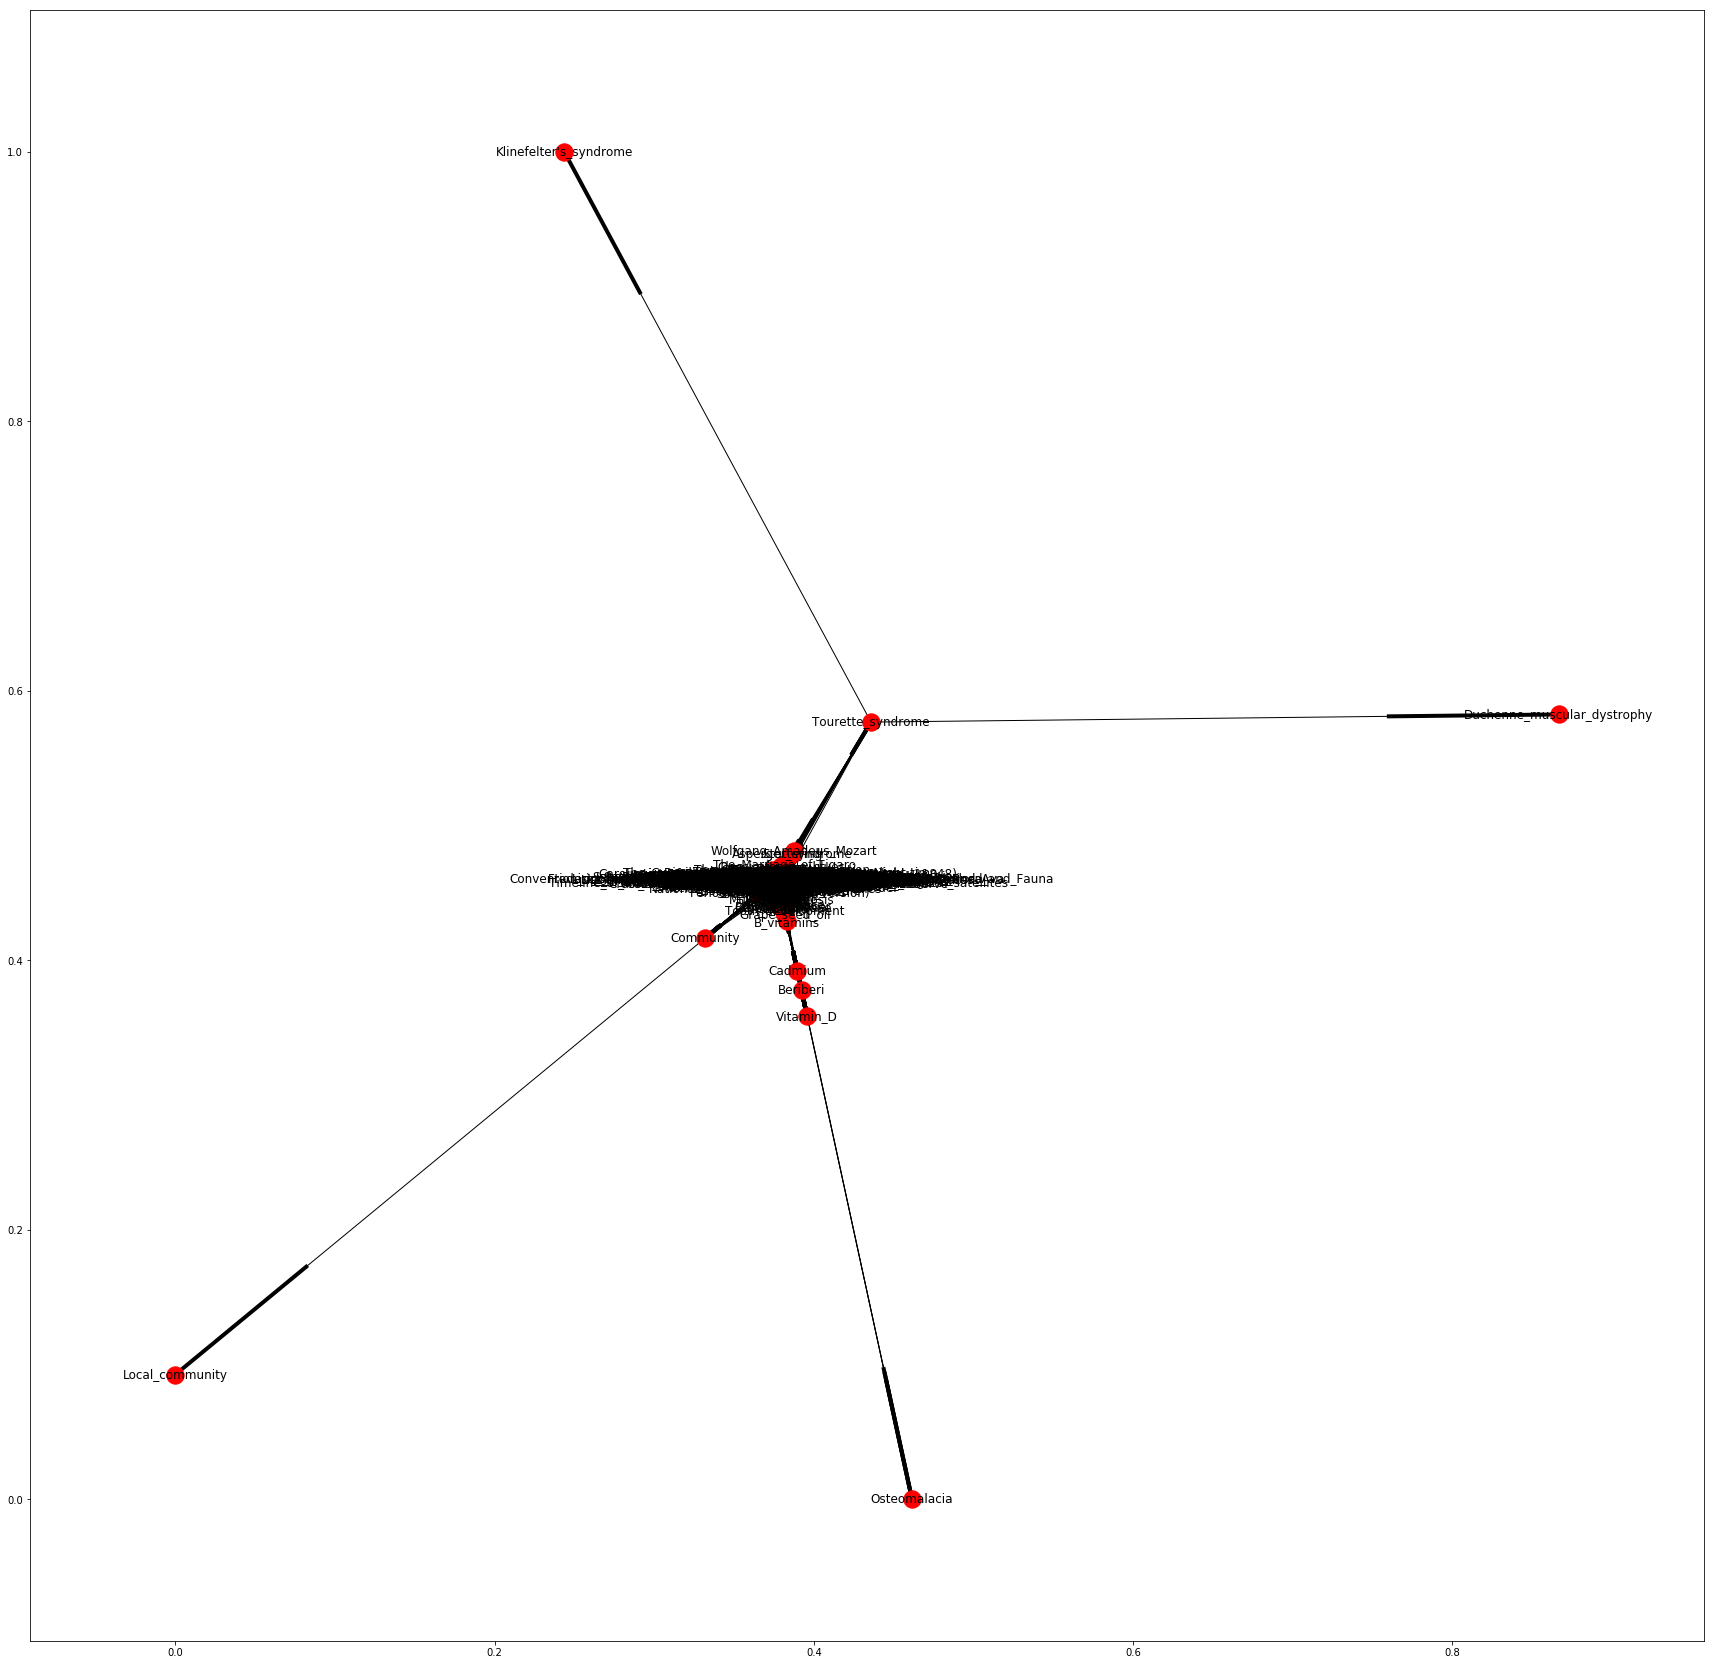

In [91]:
# takes a very long time to run, huge graph
plt.figure(figsize = (30, 30))
ax = plt.subplot()

nx.draw_networkx(DG0, ax=ax)

Then we'll use the island method to explore further, and pull in article categories.

In [92]:
def trim_edges(g, weight=1):
        g2=nx.DiGraph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        g2.add_edge(f,to,edata)
        return g2

def island_method(g, iterations=5):
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]

    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)

    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [93]:
DG2 = trim_edges(DG, 975)

islands = island_method(DG2, 25)

for i in islands: 
    # print the threshold level, size of the graph, and number of weakly connected components
    print("Threshold:", i[0], ", Size of graph:", len(i[1]), ", Number of weakly connected components:", len(list(nx.weakly_connected_components(i[1]))))

Threshold: 975 , Size of graph: 3603 , Number of weakly connected components: 12
Threshold: 976 , Size of graph: 3497 , Number of weakly connected components: 17
Threshold: 977 , Size of graph: 3398 , Number of weakly connected components: 21
Threshold: 978 , Size of graph: 3308 , Number of weakly connected components: 24
Threshold: 979 , Size of graph: 3154 , Number of weakly connected components: 31
Threshold: 980 , Size of graph: 2989 , Number of weakly connected components: 35
Threshold: 981 , Size of graph: 2823 , Number of weakly connected components: 48
Threshold: 982 , Size of graph: 2655 , Number of weakly connected components: 56
Threshold: 983 , Size of graph: 2419 , Number of weakly connected components: 68
Threshold: 984 , Size of graph: 2188 , Number of weakly connected components: 81
Threshold: 985 , Size of graph: 1956 , Number of weakly connected components: 97
Threshold: 986 , Size of graph: 1696 , Number of weakly connected components: 122
Threshold: 987 , Size of gr

In [94]:
DG1 = islands[16][1]
DG2 = islands[20][1]
DG3 = islands[24][1]

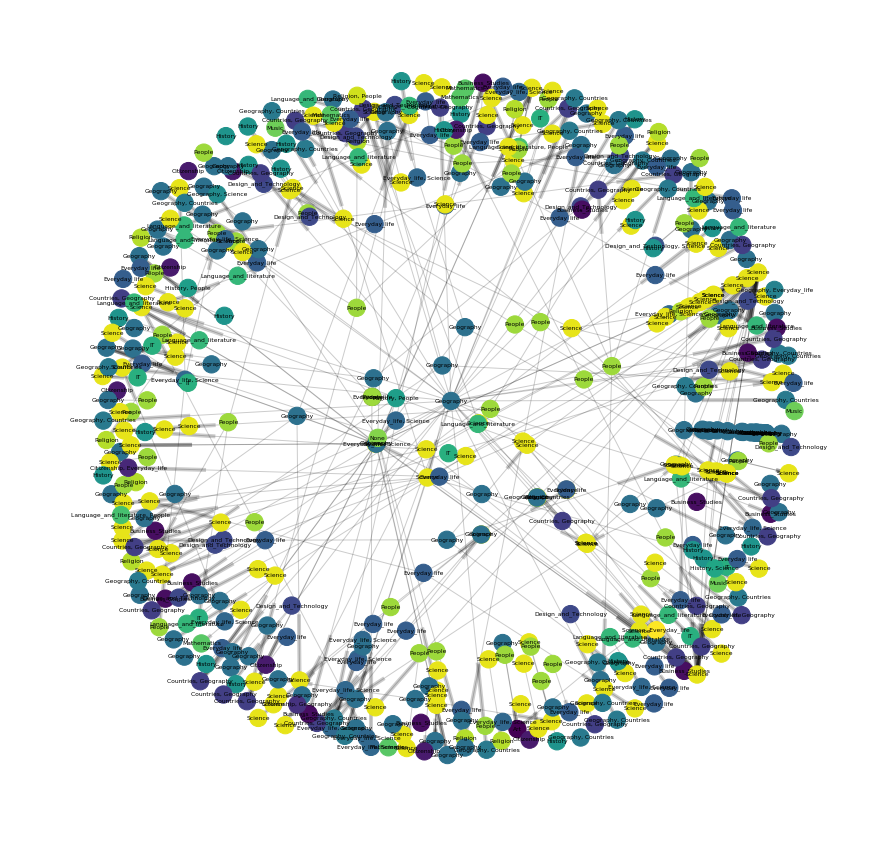

In [95]:
# Assign category attributes
for n in DG1.nodes_iter(): DG1.node[n]['category'] = 'None'
for key, value in DG_node_attr.items():
    if key in DG1.nodes():
        DG1.node[key]['category'] = value['cat0']
    else:
        continue

# get unique groups
groups = set(nx.get_node_attributes(DG1,'category').values())
mapping = dict(zip(sorted(groups),count()))
nodes = DG1.nodes()
colors = [mapping[DG1.node[n]['category']] for n in nodes]
weights=[(edata['weight']/1000) for f, t, edata in DG1.edges(data=True)]

labels_dict = nx.get_node_attributes(DG1,'category')

#initialize the figure
plt.figure(figsize = (15, 15))
ax = plt.subplot()

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(DG1)
ec = nx.draw_networkx_edges(DG1, pos, ax=ax, alpha=0.2, width=weights)
nc = nx.draw_networkx_nodes(DG1, pos, ax=ax, nodelist=nodes, node_color=colors)
labels = nx.draw_networkx_labels(DG1, pos, ax=ax, labels = labels_dict, font_size = 6)


plt.axis('off')
plt.show()

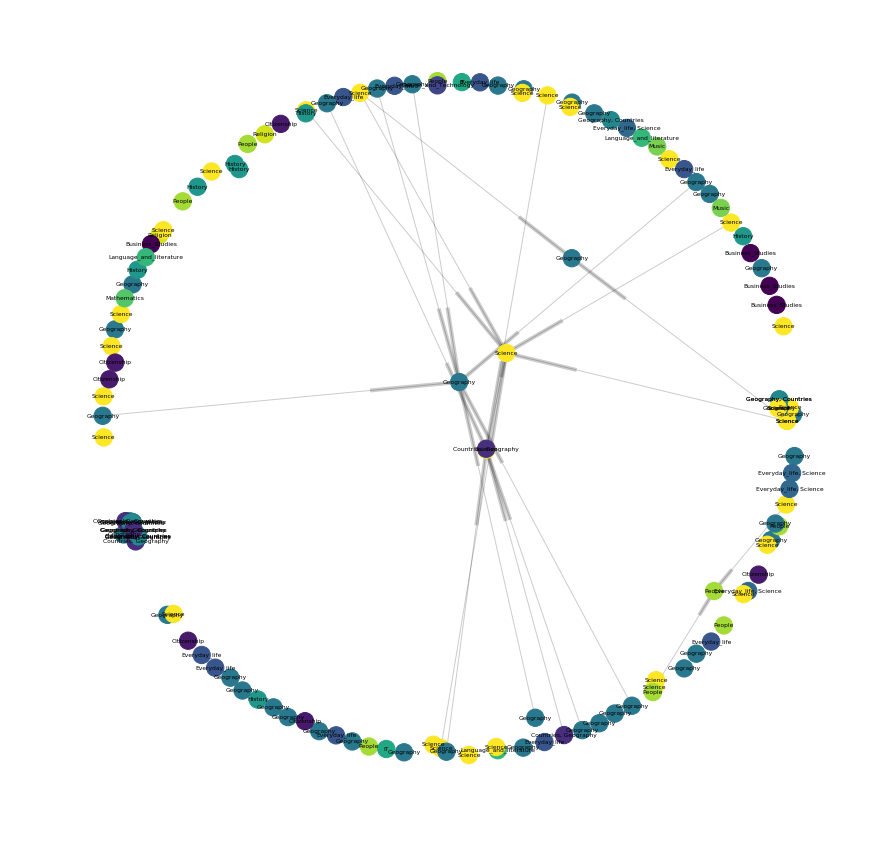

In [96]:
# assign category attributes
for n in DG2.nodes_iter(): DG2.node[n]['category'] = 'None'
for key, value in DG_node_attr.items():
    if key in DG2.nodes():
        DG2.node[key]['category'] = value['cat0']
    else:
        continue

# get unique groups
groups2 = set(nx.get_node_attributes(DG2,'category').values())
mapping2 = dict(zip(sorted(groups2),count()))
nodes2 = DG2.nodes()
colors2 = [mapping2[DG2.node[n]['category']] for n in nodes2]
weights2=[(edata['weight']/1000) for f, t, edata in DG2.edges(data=True)]

labels_dict2 = nx.get_node_attributes(DG2,'category')

#initialize the figure
plt.figure(figsize = (15, 15))
ax2 = plt.subplot()

# drawing nodes and edges separately so we can capture collection for colobar
pos2 = nx.spring_layout(DG2)
ec2 = nx.draw_networkx_edges(DG2, pos2, ax=ax2, alpha=0.2, width=weights2)
nc2 = nx.draw_networkx_nodes(DG2, pos2, ax=ax2, nodelist=nodes2, node_color=colors2)
labels2 = nx.draw_networkx_labels(DG2, pos2, ax=ax2, labels = labels_dict2, font_size = 6)


plt.axis('off')
plt.show()

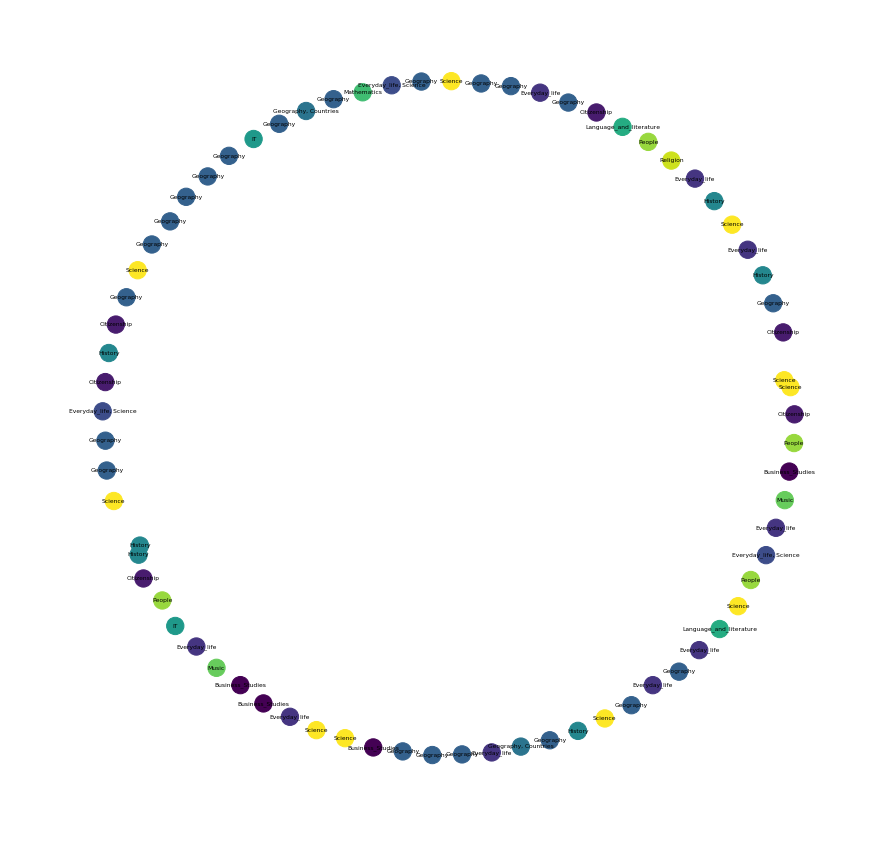

In [97]:
# assign category attributes
for n in DG3.nodes_iter(): DG3.node[n]['category'] = 'None'
for key, value in DG_node_attr.items():
    if key in DG3.nodes():
        DG3.node[key]['category'] = value['cat0']
    else:
        continue

# get unique groups
groups3 = set(nx.get_node_attributes(DG3,'category').values())
mapping3 = dict(zip(sorted(groups3),count()))
nodes3 = DG3.nodes()
colors3 = [mapping3[DG3.node[n]['category']] for n in nodes3]
weights3=[(edata['weight']/1000) for f, t, edata in DG3.edges(data=True)]

labels_dict3 = nx.get_node_attributes(DG3,'category')

#initialize the figure
plt.figure(figsize = (15, 15))
ax3 = plt.subplot()

# drawing nodes and edges separately so we can capture collection for colobar
pos3 = nx.spring_layout(DG3)
ec3 = nx.draw_networkx_edges(DG3, pos3, ax=ax3, alpha=0.2, width=weights3)
nc3 = nx.draw_networkx_nodes(DG3, pos3, ax=ax3, nodelist=nodes3, node_color=colors3)
labels3 = nx.draw_networkx_labels(DG3, pos3, ax=ax3, labels = labels_dict3, font_size = 6)


plt.axis('off')
plt.show()

Then, we can take a look at centrality measures across pages from the Links dataset.

In [98]:
def sorted_map(dd: dict) -> dict:
    """
    Sorts dict by its values (desc)
    
    :param dd: dictionary with numeric values
    :return sorted dictionary ordered by its numeric value
    """
    sorted_dict = sorted(dd.items(), key=lambda x: (-x[1], x[0]))
    sorted_dict = [(x[0], round(x[1], 4)) for x in sorted_dict]
    return sorted_dict

In [99]:
# Takes some time to run
d = nx.degree_centrality(DG)
dsm = sorted_map(d)

c = nx.closeness_centrality(DG)
csm = sorted_map(c)

b = nx.betweenness_centrality(DG)
bsm = sorted_map(b)

ident1 = [x[0] for x in dsm[:15]]
ident2 = [x[0] for x in csm[:15]]
ident3 = [x[0] for x in bsm[:15]]
ident = list(set(ident1) | set(ident2) | set(ident3))

In [100]:
summary_df = pd.DataFrame({'Page': ident,
    'Degree Centrality': [d[i] for i in ident],
    'Closeness': [c[i] for i in ident], 
    'Betweenness': [b[i] for i in ident]})


summary_df['Sum Centrality'] = sum([summary_df['Degree Centrality'],
                                   summary_df.Closeness,
                                   summary_df.Betweenness])

print('\n\n================== Most Central Pages, ccGr[0] ================\n\n')
summary_df.sort_values(by='Sum Centrality', ascending=False)



================== Most Central Pages, ccGr[0] ================




,Page,Degree Centrality,Closeness,Betweenness,Sum Centrality
15,United_States,0.401873,0.355281,0.094090,0.851245
7,United_Kingdom,0.248312,0.338741,0.042384,0.629437
10,Europe,0.237857,0.333347,0.026992,0.598195
23,England,0.201046,0.331894,0.032403,0.565343
19,France,0.227401,0.317500,0.012002,0.556903
20,Germany,0.198650,0.336069,0.019409,0.554128
9,World_War_II,0.189501,0.319284,0.015500,0.524285
21,Africa,0.150076,0.336575,0.024204,0.510855
5,English_language,0.155957,0.321463,0.014041,0.491461
14,Japan,0.146156,0.324170,0.012973,0.483299


Since the graph is directed, its PageRank can also tell us a lot about the articles

In [101]:
pr = nx.pagerank(DG)

In [102]:
sorted_map(pr)[:22]

[('United_States', 0.0096),
 ('Europe', 0.0065),
 ('France', 0.0065),
 ('United_Kingdom', 0.0062),
 ('English_language', 0.005),
 ('Germany', 0.0048),
 ('World_War_II', 0.0047),
 ('Latin', 0.0047),
 ('England', 0.0045),
 ('India', 0.0042),
 ('Japan', 0.004),
 ('Italy', 0.0038),
 ('China', 0.0037),
 ('Spain', 0.0037),
 ('Time_zone', 0.0036),
 ('Canada', 0.0035),
 ('Russia', 0.0035),
 ('Currency', 0.0034),
 ('Australia', 0.0033),
 ('Africa', 0.0032),
 ('London', 0.0031),
 ('Christianity', 0.0031)]

### exploring nltk.corpus.wordnet for semantic similarities of word

In [103]:
from nltk.corpus import wordnet as wn

In [104]:
wn.synsets('united_states')

[Synset('united_states.n.01'), Synset('united_states_government.n.01')]

In [105]:
usa = wn.synset('united_states.n.01')
china = wn.synset('china.n.01')
beetroot = wn.synset('beetroot.n.01')
china.path_similarity(usa)

0.2

In [106]:
usa.path_similarity(beetroot)

0.058823529411764705

In [107]:
china.path_similarity(beetroot)

0.058823529411764705

### using wordnet to express generality of a word

In [108]:
usa.min_depth()

9

In [109]:
china.min_depth()

9

In [110]:
beetroot.min_depth()

11

In [111]:
wn.synset('vegetable.n.01').min_depth()

6

In [112]:
wn.synset('country.n.01').min_depth()

7

In [113]:
wn.synset('river.n.01').min_depth()

5

In [114]:
wn.synset('continent.n.01').min_depth()

5

In [115]:
wn.synset('landmass.n.01').min_depth()

4

In [116]:
wn.synset('entity.n.01').min_depth()

0

##### Comparing Actual and Optimal Paths

Below we return to our finished and unfinished path dataframes, cleaning up the semi-colon separated paths into a path source and target dataframe.

In [191]:
f_paths_cleaned = pd.DataFrame([])

for i in paths_finished['path']:
    source = re.findall('^(.*?)\;',i)
    target = re.findall(';[^;]*$',i)
    f_paths_cleaned = f_paths_cleaned.append(pd.DataFrame({'source':source, 'target':target}))

In [192]:
# Drop duplicate values
f_paths_cleaned = f_paths_cleaned.drop_duplicates()
# Get rid of starting semicolon on targets
f_paths_cleaned["target"] = f_paths_cleaned["target"].str.replace(";","")

f_paths_cleaned.reset_index()
f_paths_cleaned.head()

,index,source,target
0,0,14th_century,African_slave_trade
1,0,14th_century,Greece
2,0,14th_century,John_F._Kennedy
3,0,14th_century,Fire
4,0,14th_century,Rainbow
...,...,...,...
28702,0,Yagan,Civilization
28703,0,Yagan,Fiction
28704,0,Yagan,U.S._Open_(tennis)
28705,0,"Yarralumla,_Australian_Capital_Territory",Abraham_Lincoln


In [119]:
u_paths_cleaned = pd.DataFrame([])

for i in paths_unfinished['path']:
    source = re.findall('^(.*?)\;',i)
    target = re.findall(';[^;]*$',i)
    u_paths_cleaned = u_paths_cleaned.append(pd.DataFrame({'source':source, 'target':target}))

In [120]:
# Drop duplicate values
u_paths_cleaned = u_paths_cleaned.drop_duplicates()
# get rid of starting semicolon on targets
u_paths_cleaned["target"] = u_paths_cleaned["target"].str.replace(";","")

u_paths_cleaned.reset_index()
u_paths_cleaned.head()

(16514, 2)

Finally, we can combine into one dataset, with a 3rd column of whether or not a path is finished.

In [121]:
u_paths_cleaned['finished'] = 0
f_paths_cleaned['finished'] = 1

paths_combined = f_paths_cleaned.append(u_paths_cleaned)
print(paths_combined.shape)
paths_combined.reset_index()
paths_combined.head()

(45221, 3)

We can also recreate the nx.shortest_path output from actual paths, for easy comparison.

In [171]:
# Looking for: ['Natalie_Portman', 'Romania'], list of strings
path_list = []
# append finished paths
for i in paths_finished['path']:
    list_split = str.split(i,sep=';')
    path_list.append(list(list_split))

In [172]:
for elem in path_list: 
    for i in elem: 
        if i == "<":
            elem.remove("<")

In [127]:
print(type(nx.shortest_path(DG, 'Natalie_Portman', 'Romania', weight='cos_dist')))

<class 'list'>


In [173]:
path_list

[['14th_century',
  '15th_century',
  '16th_century',
  'Pacific_Ocean',
  'Atlantic_Ocean',
  'Accra',
  'Africa',
  'Atlantic_slave_trade',
  'African_slave_trade'],
 ['14th_century',
  'Europe',
  'Africa',
  'Atlantic_slave_trade',
  'African_slave_trade'],
 ['14th_century',
  'Niger',
  'Nigeria',
  'British_Empire',
  'Slavery',
  'Africa',
  'Atlantic_slave_trade',
  'African_slave_trade'],
 ['14th_century', 'Renaissance', 'Ancient_Greece', 'Greece'],
 ['14th_century',
  'Italy',
  'Roman_Catholic_Church',
  'HIV',
  'Ronald_Reagan',
  'President_of_the_United_States',
  'John_F._Kennedy'],
 ['14th_century',
  'Europe',
  'North_America',
  'United_States',
  'President_of_the_United_States',
  'John_F._Kennedy'],
 ['14th_century', 'China', 'Gunpowder', 'Fire'],
 ['14th_century', 'Time', 'Isaac_Newton', 'Light', 'Color', 'Rainbow'],
 ['14th_century', 'Time', 'Light', 'Rainbow'],
 ['14th_century',
  '15th_century',
  'Plato',
  'Nature',
  'Ultraviolet',
  'Color',
  'Rainbow'],


In [194]:
# errors
for i in range(len(f_paths_cleaned)): 
    path = nx.shortest_path(DG, f_paths_cleaned['source'][i], f_paths_cleaned['target'][i], weight='cos_dist')
#    f_paths_cleaned['shortest_path_DG'][i] = 
    

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [185]:
f_paths_cleaned['source'].head()

0    14th_century
0    14th_century
0    14th_century
0    14th_century
0    14th_century
Name: source, dtype: object